<a href="https://colab.research.google.com/github/Gabriela2685/Accidentes/blob/main/pruebass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

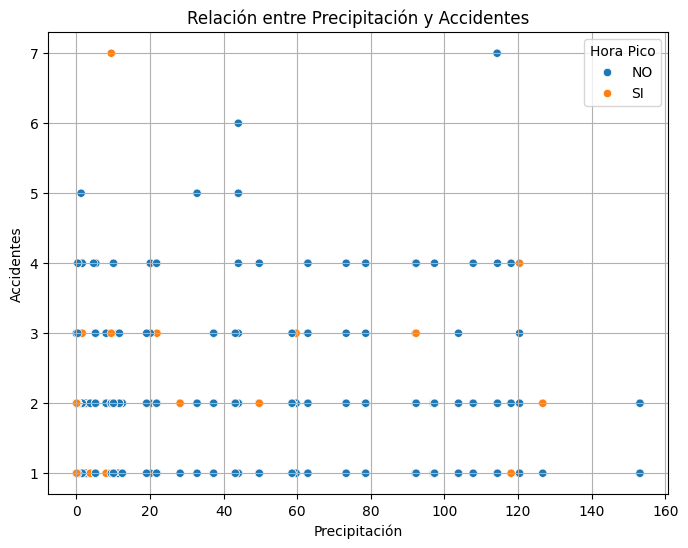

<ipython-input-1-145515770fa7>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='dia', y='acc', palette="Set3")


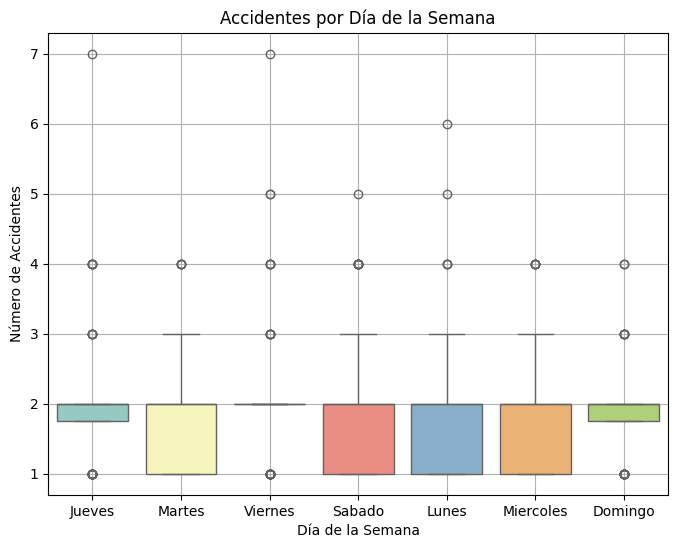

<ipython-input-1-145515770fa7>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='horario', y='acc', palette="Set2")


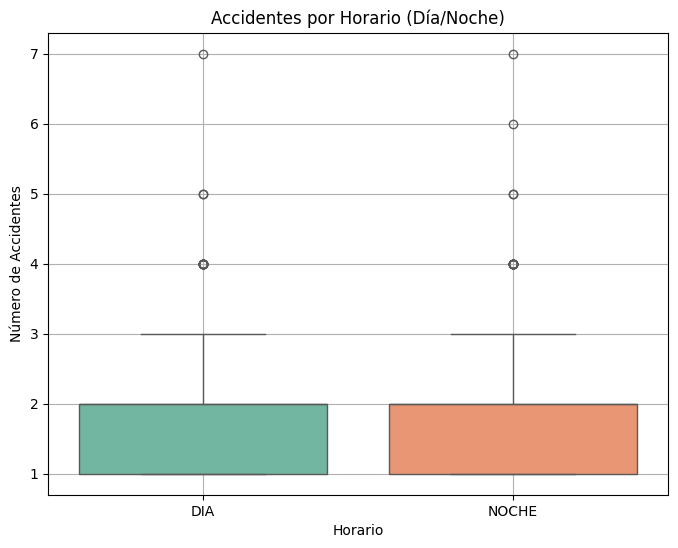

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Cargar el archivo CSV (asegúrate de ajustar el nombre del archivo si es necesario)
file_path = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vSvEd0y6NK76QorUUvJjAqRZDsJRcC_rOXBFW5gDOJ4RrqkVUHR7xXbVqnnGx45Pw/pub?output=csv'
data = pd.read_csv(file_path)

# Gráfico 1: Relación entre precipitación y accidentes
plt.figure(figsize=(8, 6))
sns.scatterplot(data=data, x='precipitacion', y='acc', hue='hora_pico')
plt.title('Relación entre Precipitación y Accidentes')
plt.xlabel('Precipitación')
plt.ylabel('Accidentes')
plt.legend(title='Hora Pico')
plt.grid(True)
plt.show()

# Gráfico 2: Accidentes por día de la semana
plt.figure(figsize=(8, 6))
sns.boxplot(data=data, x='dia', y='acc', palette="Set3")
plt.title('Accidentes por Día de la Semana')
plt.xlabel('Día de la Semana')
plt.ylabel('Número de Accidentes')
plt.grid(True)
plt.show()

# Gráfico 3: Accidentes por horario (DÍA/NOCHE)
plt.figure(figsize=(8, 6))
sns.boxplot(data=data, x='horario', y='acc', palette="Set2")
plt.title('Accidentes por Horario (Día/Noche)')
plt.xlabel('Horario')
plt.ylabel('Número de Accidentes')
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from patsy import dmatrices
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Cargar los datos
data = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vSvEd0y6NK76QorUUvJjAqRZDsJRcC_rOXBFW5gDOJ4RrqkVUHR7xXbVqnnGx45Pw/pub?output=csv')

# Convertir variables categóricas en numéricas (si es necesario)
data['hora_pico'] = data['hora_pico'].map({'SI': 1, 'NO': 0})
data['horario'] = data['horario'].map({'DIA': 0, 'NOCHE': 1})
data['tipo_de_interseccion'] = data['tipo_de_interseccion'].astype('category').cat.codes
data['dia'] = data['dia'].astype('category').cat.codes
data['dia_1'] = data['dia_1'].map({'Entre semana': 0, 'Fin de semana': 1})

# Dividir los datos en entrenamiento y prueba
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Fórmula del modelo
formula = """acc ~ precipitacion + hora_pico + horario + tipo_de_interseccion + dia + dia_1"""

# Crear las matrices para el modelo
y_train, X_train = dmatrices(formula, train_data, return_type='dataframe')
y_test, X_test = dmatrices(formula, test_data, return_type='dataframe')

# Ajustar el modelo de Poisson
poisson_model = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
print(poisson_model.summary())

# Diagnóstico: Verificar la sobredispersión
train_data['lambda_hat'] = poisson_model.mu  # Cambiar nombre de la columna 'lambda'
train_data['aux_ols_dep'] = ((train_data['acc'] - train_data['lambda_hat'])**2 - train_data['lambda_hat']) / train_data['lambda_hat']

# Ajustar un modelo de dispersión (OLS)
ols_formula = """aux_ols_dep ~ lambda_hat - 1"""
aux_ols_model = smf.ols(ols_formula, data=train_data).fit()
print(f"Parámetro alpha para Binomial Negativa: {aux_ols_model.params[0]}")

# Ajustar el modelo de Binomial Negativa si hay sobredispersión
nb2_model = sm.GLM(y_train, X_train, family=sm.families.NegativeBinomial(alpha=aux_ols_model.params[0])).fit()
print(nb2_model.summary())

# Hacer predicciones en el conjunto de prueba
nb2_predictions = nb2_model.get_prediction(X_test)
predictions_summary = nb2_predictions.summary_frame()

# Comparar predicciones con valores reales
predicted_counts = predictions_summary['mean']
actual_counts = y_test['acc']

# Visualizar resultados
plt.figure(figsize=(10, 6))
plt.plot(predicted_counts.values, label='Predicciones', marker='o')
plt.plot(actual_counts.values, label='Reales', marker='x')
plt.title('Accidentes Predichos vs Reales')
plt.xlabel('Índice')
plt.ylabel('Número de Accidentes')
plt.legend()
plt.grid()
plt.show()


                 Generalized Linear Model Regression Results                  
Dep. Variable:                    acc   No. Observations:                  479
Model:                            GLM   Df Residuals:                      472
Model Family:                 Poisson   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -680.96
Date:                Sat, 28 Dec 2024   Deviance:                       154.19
Time:                        22:59:47   Pearson chi2:                     173.
No. Iterations:                     4   Pseudo R-squ. (CS):           0.005076
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.6236 

<ipython-input-3-4f0cdf0dab79>:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Parámetro alpha para Binomial Negativa: {aux_ols_model.params[0]}")
<ipython-input-3-4f0cdf0dab79>:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  nb2_model = sm.GLM(y_train, X_train, family=sm.families.NegativeBinomial(alpha=aux_ols_model.params[0])).fit()
/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: invalid value encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)


ValueError: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    acc   No. Observations:                  479
Model:                            GLM   Df Residuals:                      472
Model Family:                 Poisson   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -680.96
Date:                Sat, 28 Dec 2024   Deviance:                       154.19
Time:                        22:59:59   Pearson chi2:                     173.
No. Iterations:                     4   Pseudo R-squ. (CS):           0.005076
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.6236 

<ipython-input-4-3e9936d4edc6>:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Parámetro alpha para Binomial Negativa: {aux_ols_model.params[0]}")
<ipython-input-4-3e9936d4edc6>:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = aux_ols_model.params[0]


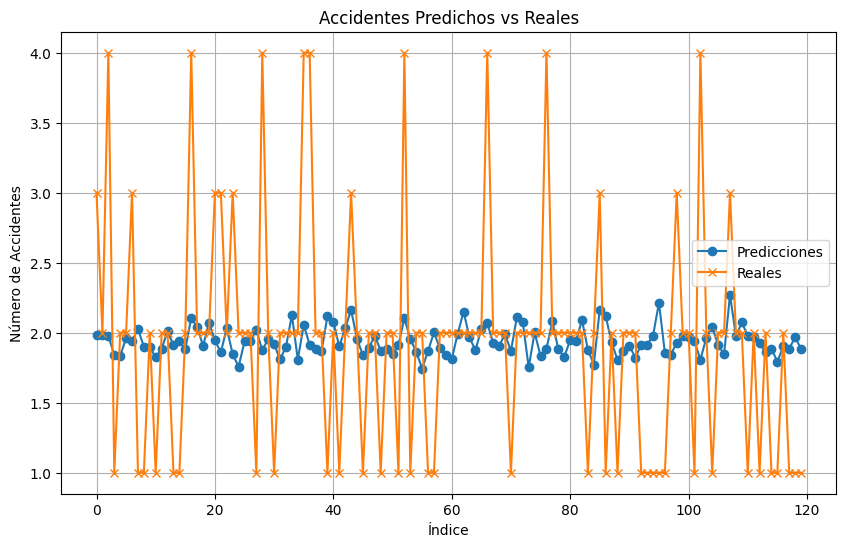

In [ ]:
import pandas as pd
import numpy as np
from patsy import dmatrices
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Cargar los datos
data = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vSvEd0y6NK76QorUUvJjAqRZDsJRcC_rOXBFW5gDOJ4RrqkVUHR7xXbVqnnGx45Pw/pub?output=csv')

# Convertir variables categóricas en numéricas (si es necesario)
data['hora_pico'] = data['hora_pico'].map({'SI': 1, 'NO': 0})
data['horario'] = data['horario'].map({'DIA': 0, 'NOCHE': 1})
data['tipo_de_interseccion'] = data['tipo_de_interseccion'].astype('category').cat.codes
data['dia'] = data['dia'].astype('category').cat.codes
data['dia_1'] = data['dia_1'].map({'Entre semana': 0, 'Fin de semana': 1})

# Dividir los datos en entrenamiento y prueba
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Fórmula del modelo
formula = """acc ~ precipitacion + hora_pico + horario + tipo_de_interseccion + dia + dia_1"""

# Crear las matrices para el modelo
y_train, X_train = dmatrices(formula, train_data, return_type='dataframe')
y_test, X_test = dmatrices(formula, test_data, return_type='dataframe')

# Ajustar el modelo de Poisson
poisson_model = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
print(poisson_model.summary())

# Diagnóstico: Verificar la sobredispersión
train_data['lambda_hat'] = poisson_model.mu  # Cambiar nombre de la columna 'lambda'
train_data['aux_ols_dep'] = ((train_data['acc'] - train_data['lambda_hat'])**2 - train_data['lambda_hat']) / train_data['lambda_hat']

# Ajustar un modelo de dispersión (OLS)
ols_formula = """aux_ols_dep ~ lambda_hat - 1"""
aux_ols_model = smf.ols(ols_formula, data=train_data).fit()
print(f"Parámetro alpha para Binomial Negativa: {aux_ols_model.params[0]}")

# Ensure alpha is positive and not too small
alpha = aux_ols_model.params[0]
# If alpha is negative or very close to 0, set it to a small positive value
if alpha <= 0.01:
    alpha = 0.01  # or another small positive value
    print("Alpha adjusted to 0.01 to avoid boundary issues.")

# Ajustar el modelo de Binomial Negativa si hay sobredispersión
nb2_model = sm.GLM(y_train, X_train, family=sm.families.NegativeBinomial(alpha=alpha)).fit() # Use adjusted alpha
print(nb2_model.summary())

# Hacer predicciones en el conjunto de prueba
nb2_predictions = nb2_model.get_prediction(X_test)
predictions_summary = nb2_predictions.summary_frame()

# Comparar predicciones con valores reales
predicted_counts = predictions_summary['mean']
actual_counts = y_test['acc']

# Visualizar resultados
plt.figure(figsize=(10, 6))
plt.plot(predicted_counts.values, label='Predicciones', marker='o')
plt.plot(actual_counts.values, label='Reales', marker='x')
plt.title('Accidentes Predichos vs Reales')
plt.xlabel('Índice')
plt.ylabel('Número de Accidentes')
plt.legend()
plt.grid()
plt.show()


In [ ]:
# Calcular la media y la varianza
mean_acc = data['acc'].mean()
var_acc = data['acc'].var()

print(f"Media de acc: {mean_acc}")
print(f"Varianza de acc: {var_acc}")

# Comparación
if var_acc > mean_acc:
    print("La varianza es mayor que la media: hay indicios de sobredispersión.")
else:
    print("La varianza es menor o igual a la media: no hay sobredispersión.")


Media de acc: 1.9465776293823038
Varianza de acc: 0.7095158597662724
La varianza es menor o igual a la media: no hay sobredispersión.


                 Generalized Linear Model Regression Results                  
Dep. Variable:                    acc   No. Observations:                  479
Model:                            GLM   Df Residuals:                      467
Model Family:                 Poisson   Df Model:                           11
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -680.78
Date:                Sat, 28 Dec 2024   Deviance:                       153.83
Time:                        23:02:48   Pearson chi2:                     172.
No. Iterations:                     4   Pseudo R-squ. (CS):           0.005809
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.6315 

<ipython-input-10-5fd77cfa7ce3>:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Parámetro alpha para Binomial Negativa: {aux_ols_model.params[0]}")
<ipython-input-10-5fd77cfa7ce3>:54: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = max(aux_ols_model.params[0], 0.01)


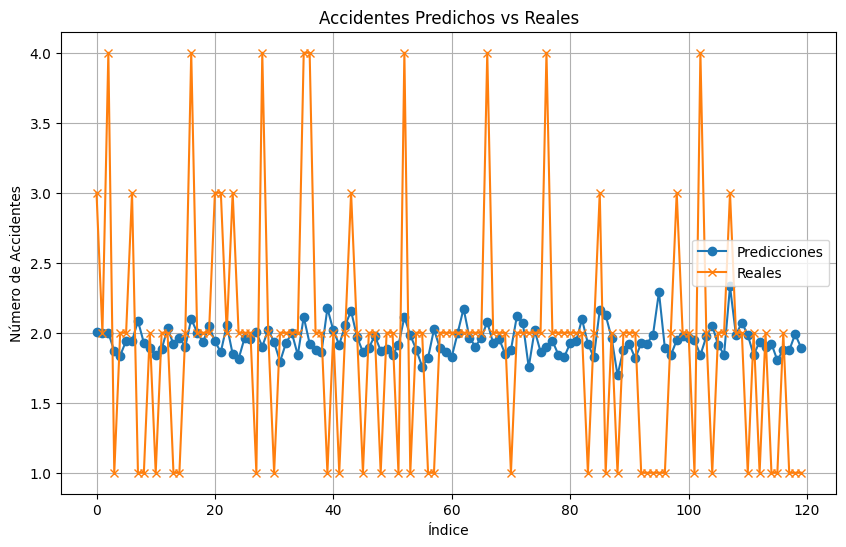

In [ ]:
import pandas as pd
import numpy as np
from patsy import dmatrices
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Cargar los datos
data = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vSvEd0y6NK76QorUUvJjAqRZDsJRcC_rOXBFW5gDOJ4RrqkVUHR7xXbVqnnGx45Pw/pub?output=csv')

# Convertir variables categóricas en numéricas
data['hora_pico'] = data['hora_pico'].map({'SI': 1, 'NO': 0})
data['horario'] = data['horario'].map({'DIA': 0, 'NOCHE': 1})
data['tipo_de_interseccion'] = data['tipo_de_interseccion'].astype('category').cat.codes
data['dia'] = data['dia'].astype('category').cat.codes
data['dia_1'] = data['dia_1'].map({'Entre semana': 0, 'Fin de semana': 1})
data['mediana'] = data['mediana'].map({'SI': 1, 'NO': 0})  # Nueva variable

# Crear interacciones adicionales
data['precip_hora_pico'] = data['precipitacion'] * data['hora_pico']
data['precip_horario'] = data['precipitacion'] * data['horario']
data['mediana_carriles'] = data['mediana'] * data['carriles']  # Nueva interacción

# Dividir los datos en entrenamiento y prueba
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Fórmula del modelo (actualizada con las nuevas variables)
formula = (
    "acc ~ precipitacion + hora_pico + horario + tipo_de_interseccion + dia + dia_1 + "
    "carriles + mediana + precip_hora_pico + precip_horario + mediana_carriles"
)

# Crear las matrices para el modelo
y_train, X_train = dmatrices(formula, train_data, return_type='dataframe')
y_test, X_test = dmatrices(formula, test_data, return_type='dataframe')

# Ajustar el modelo de Poisson
poisson_model = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
print(poisson_model.summary())

# Diagnóstico: Verificar la sobredispersión
train_data['lambda_hat'] = poisson_model.mu
train_data['aux_ols_dep'] = (
    (train_data['acc'] - train_data['lambda_hat'])**2 - train_data['lambda_hat']
) / train_data['lambda_hat']

# Ajustar un modelo de dispersión (OLS)
ols_formula = "aux_ols_dep ~ lambda_hat - 1"
aux_ols_model = smf.ols(ols_formula, data=train_data).fit()
print(f"Parámetro alpha para Binomial Negativa: {aux_ols_model.params[0]}")

# Asegurarse de que alpha sea positivo y no muy pequeño
alpha = max(aux_ols_model.params[0], 0.01)

# Ajustar el modelo de Binomial Negativa si hay sobredispersión
nb2_model = sm.GLM(y_train, X_train, family=sm.families.NegativeBinomial(alpha=alpha)).fit()
print(nb2_model.summary())

# Hacer predicciones en el conjunto de prueba
nb2_predictions = nb2_model.get_prediction(X_test)
predictions_summary = nb2_predictions.summary_frame()

# Comparar predicciones con valores reales
predicted_counts = predictions_summary['mean']
actual_counts = y_test['acc']

# Visualizar resultados
plt.figure(figsize=(10, 6))
plt.plot(predicted_counts.values, label='Predicciones', marker='o')
plt.plot(actual_counts.values, label='Reales', marker='x')
plt.title('Accidentes Predichos vs Reales')
plt.xlabel('\u00cdndice')
plt.ylabel('Número de Accidentes')
plt.legend()
plt.grid()
plt.show()


                 Generalized Linear Model Regression Results                  
Dep. Variable:                    acc   No. Observations:                   40
Model:                            GLM   Df Residuals:                       38
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -208.24
Date:                Sat, 04 Jan 2025   Deviance:                       170.37
Time:                        05:20:29   Pearson chi2:                     174.
No. Iterations:                     4   Pseudo R-squ. (CS):            0.08576
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         4.3160      0.022    192.295

<ipython-input-8-05de843e79f3>:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Parámetro alpha para Binomial Negativa: {aux_ols_model.params[0]}")
<ipython-input-8-05de843e79f3>:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = max(aux_ols_model.params[0], 0.01) # Changed 'ols_model' to 'aux_ols_model'


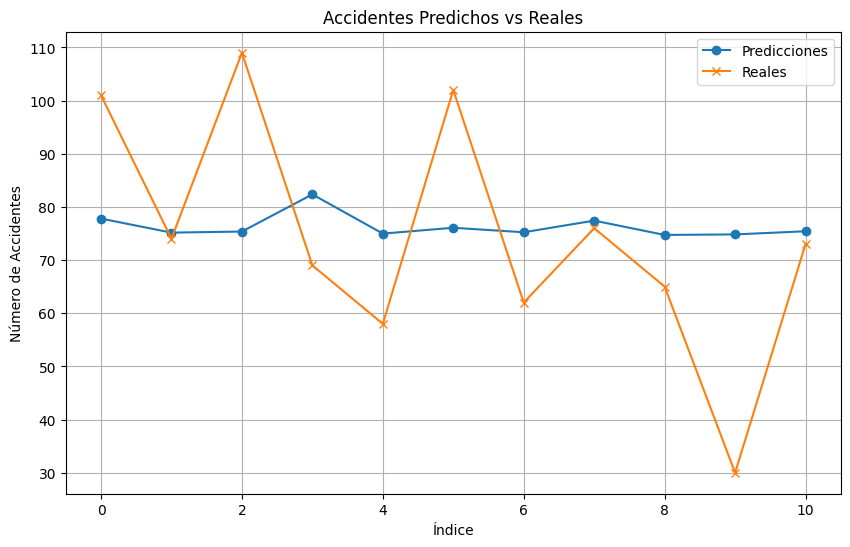

In [ ]:
import pandas as pd
import numpy as np
from patsy import dmatrices
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Crear el DataFrame basado en tus datos
data = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vR4i3H4XvouTd3J3XcXSxervyxSejeHpwEBxt9_AwJU3X0mhMfWeBYdT9tG3ZtAkA/pub?output=csv')

# Convertir la columna 'dia' a formato de fecha
data['dia'] = pd.to_datetime(data['dia'], dayfirst=True)

# Dividir los datos en entrenamiento y prueba
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Fórmula del modelo (solo incluye precipitación)
formula = "acc ~ precipitacion"

# Crear las matrices para el modelo
y_train, X_train = dmatrices(formula, train_data, return_type='dataframe')
y_test, X_test = dmatrices(formula, test_data, return_type='dataframe')

# Ajustar el modelo de Poisson
poisson_model = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
print(poisson_model.summary())

# Diagnóstico: Verificar la sobredispersión
train_data['lambda_hat'] = poisson_model.mu  # Valor esperado
train_data['aux_ols_dep'] = ((train_data['acc'] - train_data['lambda_hat'])**2 - train_data['lambda_hat']) / train_data['lambda_hat']

# Ajustar un modelo de dispersión (OLS)
ols_formula = """aux_ols_dep ~ lambda_hat - 1"""
aux_ols_model = smf.ols(ols_formula, data=train_data).fit()
print(f"Parámetro alpha para Binomial Negativa: {aux_ols_model.params[0]}")

# Asegurar que alpha sea positivo y razonable
alpha = max(aux_ols_model.params[0], 0.01) # Changed 'ols_model' to 'aux_ols_model'
print(f"Alpha ajustado: {alpha}")

# Ajustar el modelo de Binomial Negativa (si es necesario)
nb2_model = sm.GLM(y_train, X_train, family=sm.families.NegativeBinomial(alpha=alpha)).fit()
print(nb2_model.summary())

# Hacer predicciones en el conjunto de prueba
nb2_predictions = nb2_model.get_prediction(X_test)
predictions_summary = nb2_predictions.summary_frame()

# Comparar predicciones con valores reales
predicted_counts = predictions_summary['mean']
actual_counts = y_test['acc']

# Visualizar resultados
plt.figure(figsize=(10, 6))
plt.plot(predicted_counts.values, label='Predicciones', marker='o')
plt.plot(actual_counts.values, label='Reales', marker='x')
plt.title('Accidentes Predichos vs Reales')
plt.xlabel('Índice')
plt.ylabel('Número de Accidentes')
plt.legend()
plt.grid()
plt.show()


                 Generalized Linear Model Regression Results                  
Dep. Variable:                    acc   No. Observations:                  292
Model:                            GLM   Df Residuals:                      280
Model Family:                 Poisson   Df Model:                           11
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1017.1
Date:                Sun, 05 Jan 2025   Deviance:                       79.240
Time:                        23:51:21   Pearson chi2:                     78.1
No. Iterations:                     4   Pseudo R-squ. (CS):             0.9718
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          4.562e+05   7.35e+0

<ipython-input-12-87a171ca49c5>:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Parámetro alpha para Binomial Negativa: {aux_ols_model.params[0]}")
<ipython-input-12-87a171ca49c5>:48: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = max(aux_ols_model.params[0], 0.01)
/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:586: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/usr/local/lib/python3.10/dist-packages/statsmodels

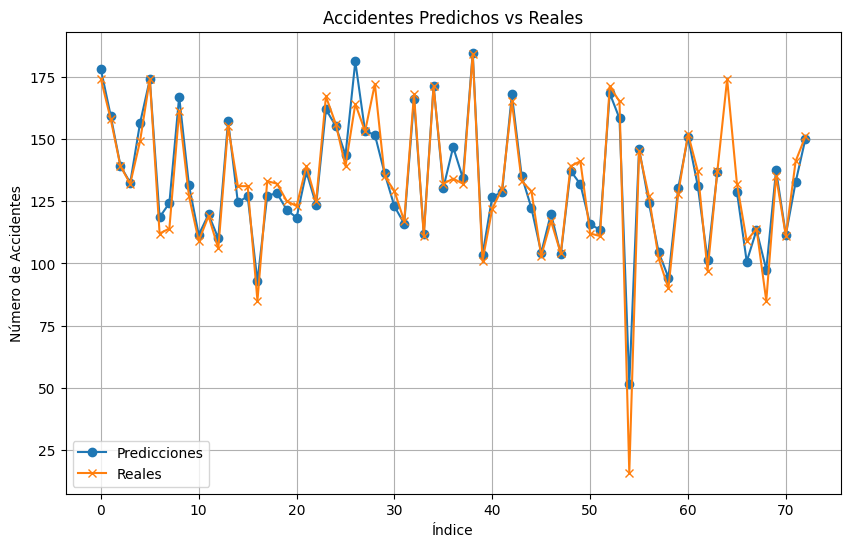

In [ ]:
import pandas as pd
import numpy as np
from patsy import dmatrices
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Cargar los datos
data = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vR4i3H4XvouTd3J3XcXSxervyxSejeHpwEBxt9_AwJU3X0mhMfWeBYdT9tG3ZtAkA/pub?output=csv')

# Convertir variables categóricas en numéricas (si es necesario)
data['dia_2'] = data['dia_2'].map({'Entre semana': 0, 'Fin de semana': 1})
data['dia_1'] = data['dia_1'].map({
    'lunes': 1, 'martes': 2, 'miércoles': 3, 'jueves': 4, 'viernes': 5,
    'sábado': 6, 'domingo': 7
})  # Mapear días de la semana a valores numéricos

# Dividir los datos en entrenamiento y prueba
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Fórmula del modelo
formula = ("""acc ~ TPDA_aprox + p_no_semaforizada + p_semaforizada + dia_1 + dia_2 +"""
          """interseccion_Y + interseccion_T + interseccion_X + interseccion_RM +"""
          """LV_40 + LV_50 + LV_80"""
)

# Crear las matrices para el modelo
y_train, X_train = dmatrices(formula, train_data, return_type='dataframe')
y_test, X_test = dmatrices(formula, test_data, return_type='dataframe')

# Ajustar el modelo de Poisson
poisson_model = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
print(poisson_model.summary())

# Diagnóstico: Verificar la sobredispersión
train_data['lambda_hat'] = poisson_model.mu  # Predicciones ajustadas
train_data['aux_ols_dep'] = (
    (train_data['acc'] - train_data['lambda_hat'])**2 - train_data['lambda_hat']
) / train_data['lambda_hat']

# Ajustar un modelo de dispersión (OLS)
ols_formula = """aux_ols_dep ~ lambda_hat - 1"""
aux_ols_model = smf.ols(ols_formula, data=train_data).fit()
print(f"Parámetro alpha para Binomial Negativa: {aux_ols_model.params[0]}")

# Asegurarse de que alpha sea positivo
alpha = max(aux_ols_model.params[0], 0.01)

# Ajustar el modelo de Binomial Negativa si hay sobredispersión
nb2_model = sm.GLM(y_train, X_train, family=sm.families.NegativeBinomial(alpha=alpha)).fit()
print(nb2_model.summary())

# Hacer predicciones en el conjunto de prueba
nb2_predictions = nb2_model.get_prediction(X_test)
predictions_summary = nb2_predictions.summary_frame()

# Comparar predicciones con valores reales
predicted_counts = predictions_summary['mean']
actual_counts = y_test['acc']

# Visualizar resultados
plt.figure(figsize=(10, 6))
plt.plot(predicted_counts.values, label='Predicciones', marker='o')
plt.plot(actual_counts.values, label='Reales', marker='x')
plt.title('Accidentes Predichos vs Reales')
plt.xlabel('Índice')
plt.ylabel('Número de Accidentes')
plt.legend()
plt.grid()
plt.show()


                 Generalized Linear Model Regression Results                  
Dep. Variable:                    acc   No. Observations:                  292
Model:                            GLM   Df Residuals:                      284
Model Family:                 Poisson   Df Model:                            7
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1058.5
Date:                Mon, 06 Jan 2025   Deviance:                       162.02
Time:                        00:12:56   Pearson chi2:                     161.
No. Iterations:                     4   Pseudo R-squ. (CS):             0.9626
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              6.3012      0

<ipython-input-15-5cebdf66ea52>:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Parámetro alpha para Binomial Negativa: {aux_ols_model.params[0]}")
<ipython-input-15-5cebdf66ea52>:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = max(aux_ols_model.params[0], 0.01)


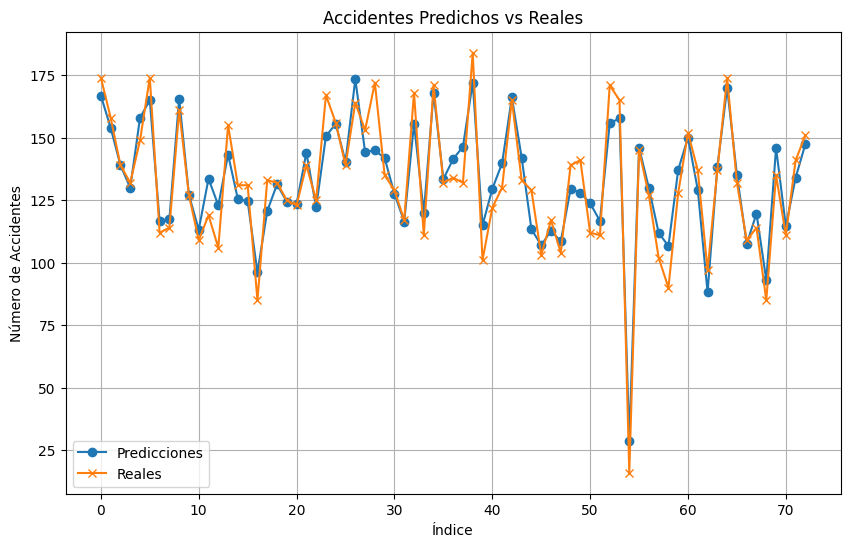

In [ ]:
import pandas as pd
import numpy as np
from patsy import dmatrices
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Cargar los datos
data = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vR4i3H4XvouTd3J3XcXSxervyxSejeHpwEBxt9_AwJU3X0mhMfWeBYdT9tG3ZtAkA/pub?output=csv')

# Convertir variables categóricas en numéricas (si es necesario)
data['dia_2'] = data['dia_2'].map({'Entre semana': 0, 'Fin de semana': 1})
data['dia_1'] = data['dia_1'].map({
    'lunes': 1, 'martes': 2, 'miércoles': 3, 'jueves': 4, 'viernes': 5,
    'sábado': 6, 'domingo': 7
})  # Mapear días de la semana a valores numéricos

# Dividir los datos en entrenamiento y prueba
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Fórmula del modelo
formula = ("""acc ~ np.log(TPDA_aprox) + p_no_semaforizada + p_semaforizada + dia_2 +"""
          """interseccion_Y + interseccion_T + interseccion_X + interseccion_RM"""
)

# Crear las matrices para el modelo
y_train, X_train = dmatrices(formula, train_data, return_type='dataframe')
y_test, X_test = dmatrices(formula, test_data, return_type='dataframe')

# Ajustar el modelo de Poisson
poisson_model = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
print(poisson_model.summary())

# Diagnóstico: Verificar la sobredispersión
train_data['lambda_hat'] = poisson_model.mu  # Predicciones ajustadas
train_data['aux_ols_dep'] = (
    (train_data['acc'] - train_data['lambda_hat'])**2 - train_data['lambda_hat']
) / train_data['lambda_hat']

# Ajustar un modelo de dispersión (OLS)
ols_formula = """aux_ols_dep ~ lambda_hat - 1"""
aux_ols_model = smf.ols(ols_formula, data=train_data).fit()
print(f"Parámetro alpha para Binomial Negativa: {aux_ols_model.params[0]}")

# Asegurarse de que alpha sea positivo
alpha = max(aux_ols_model.params[0], 0.01)

# Ajustar el modelo de Binomial Negativa si hay sobredispersión
nb2_model = sm.GLM(y_train, X_train, family=sm.families.NegativeBinomial(alpha=alpha)).fit()
print(nb2_model.summary())

# Hacer predicciones en el conjunto de prueba
nb2_predictions = nb2_model.get_prediction(X_test)
predictions_summary = nb2_predictions.summary_frame()

# Comparar predicciones con valores reales
predicted_counts = predictions_summary['mean']
actual_counts = y_test['acc']

# Visualizar resultados
plt.figure(figsize=(10, 6))
plt.plot(predicted_counts.values, label='Predicciones', marker='o')
plt.plot(actual_counts.values, label='Reales', marker='x')
plt.title('Accidentes Predichos vs Reales')
plt.xlabel('Índice')
plt.ylabel('Número de Accidentes')
plt.legend()
plt.grid()
plt.show()
